# Random Forest

**Project Goal**: To expand the decision tree model into an entire forest (an example of something called an ensemble model); use a grid search cv to tune hyperparameters; and create a function that loads data and a pre-trained model, and uses that model to generate a Series of predictions.

In [4]:
import gzip
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

#### Import Data

In [5]:
def wrangle(url):
    df = pd.read_csv(url)
    #Re-code the class variable to True = 1, and False = 0:
    df['class'] = df['class'].replace({0: False, 1: True})
    
    #Rename the class variable to bankrupt
    df = df.rename(columns={'class': 'bankrupt'}) #.set_index("year")

    return df

In [6]:
df = wrangle("https://archive.ics.uci.edu/static/public/365/data.csv")
df.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_14680\3935766308.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({0: False, 1: True})


,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A56,A57,A58,A59,A60,A61,A62,A63,A64,bankrupt
0,1,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,False
1,1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,False
2,1,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,False
3,1,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,False
4,1,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,False


#### Split Data

Split data vertically into X (the features) and y(the target)

In [7]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (43405, 65)
y shape: (43405,)


Split Data horizontally - train and test sets:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34724, 65)
y_train shape: (34724,)
X_test shape: (8681, 65)
y_test shape: (8681,)


Resample

In [9]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (66098, 65)


,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64
0,4,-0.013224,0.398380,-0.042533,0.83862,-26.922,-0.070108,-0.007444,1.5102,0.710170,...,-2735.00,0.005017,-0.021980,1.01000,0.090420,118.420,3.715600,135.450,2.694600,0.91166
1,4,0.048354,0.396080,0.586460,2.48060,20.699,0.207470,0.072721,1.5247,5.615400,...,554.46,0.002328,0.080067,0.98728,0.000000,22.074,16.626000,25.746,14.177000,321.75000
2,2,-0.452000,0.070426,0.892070,13.66700,393.340,1.043400,-0.452000,13.1990,0.237890,...,5011.40,-0.449260,-0.486250,2.62110,0.000000,NaN,0.838730,108.060,3.377900,6.34300
3,2,-0.020526,0.273260,0.070290,1.26050,17.946,-0.020526,-0.020526,2.5029,0.995670,...,871.98,-0.004346,-0.030012,1.00430,0.004955,44.113,3.207300,101.840,3.583900,1.46580
4,2,-0.170790,0.335700,-0.153930,0.54147,-332.990,-0.170790,-0.170790,1.9185,0.018351,...,-17021.00,-53.493000,-0.265180,54.49300,0.000000,NaN,0.034089,37818.000,0.009652,0.00396


#### Build Model

Baseline Model: Accuracy

In [10]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9518


- The baseline model predicts a single outcome. The question is whether it is the rigt prediction.
-  If we could somehow use more than one model simultaneously, we'd have a more trustworthy prediction.
- **Ensemble models** work by building multiple models on random subsets of the same data, and then comparing their predictions to make a final prediction. 
- The next step is to create an ensemble of trees here. This type of model is called a **random forest.**

Iterate

In [11]:
clf = make_pipeline(SimpleImputer(),
                    RandomForestClassifier(random_state=42)
                   )
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


Cross-Validation

In [12]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.99848714 0.99765507 0.99765507 0.99795749 0.99750359]


- The accuracy scores indicate that the model better than the baseline model.
- Therefore, it will be able to generalize better than the baseline model.

#### Hyperparameter Tuning

- The first step is creating a range of hyperparameters that we want to evaluate.

Parameter Grid:

- Involves creating a dictionary with the range of hyperparameters that we want to evaluate for our classifier.

- The thing is to create a dictionary with the range of hyperparameters that we want to evaluate for our classifier

In [17]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth":range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

Grid Search

In [18]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

Fit Model

In [19]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

Grid Search Cv Results

In [20]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,27.335323,0.930886,0.179734,0.037051,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.943192,0.947050,0.951513,0.947122,0.952947,0.948365,0.003491,20
1,28.517906,0.875894,0.178533,0.018308,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.936838,0.938200,0.944478,0.938346,0.945836,0.940740,0.003670,23
2,53.222326,1.026893,0.264554,0.009700,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.943949,0.947050,0.948790,0.945079,0.949921,0.946958,0.002224,21
3,63.509145,9.409847,0.400159,0.082463,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.937141,0.938275,0.942284,0.940767,0.943339,0.940361,0.002343,24
4,102.370671,1.450247,0.389316,0.017050,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.944554,0.949395,0.950000,0.947500,0.950526,0.948395,0.002176,19
5,89.835235,5.754002,0.377102,0.016220,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.939939,0.940847,0.942890,0.943112,0.943415,0.942041,0.001385,22
6,36.518415,0.475238,0.225034,0.005892,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996823,0.995159,0.995537,0.995764,0.995234,0.995703,0.000600,15
7,38.186385,0.498563,0.223618,0.011400,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.995991,0.994402,0.994629,0.994705,0.993494,0.994644,0.000800,18
8,69.943016,2.020059,0.364862,0.021966,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996823,0.995840,0.995915,0.996142,0.995461,0.996036,0.000450,14
9,72.419040,2.464229,0.443266,0.060357,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996142,0.995083,0.995234,0.995385,0.994099,0.995189,0.000655,17


Training Time vs N estimates

- First thing is to create a mask for cv_results for rows where "param_randomforestclassifier__max_depth" equals 10. Then plot "param_randomforestclassifier__n_estimators" on the x-axis and "mean_fit_time" on the y-axis.

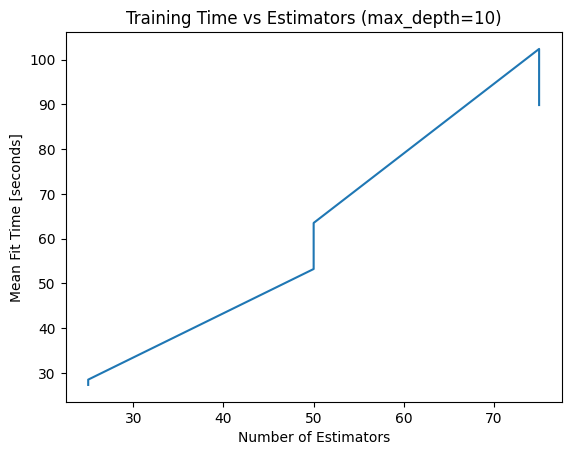

In [21]:
# Create mask
mask=cv_results["param_randomforestclassifier__max_depth"] == 10
#cv_results[mask]
# Plot fit time vs n_estimators

# Label axes
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
    
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

Training time vs max depth

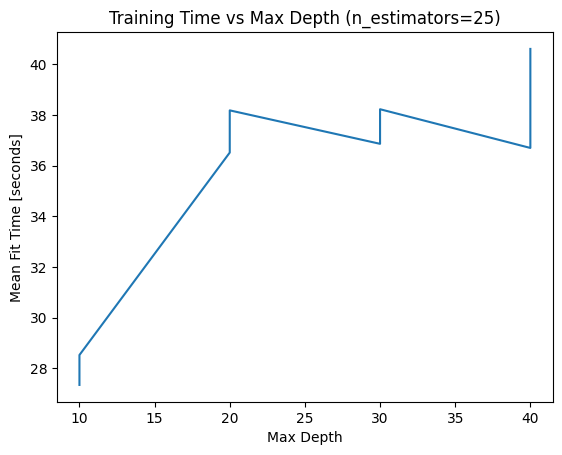

In [22]:
# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"] == 25
# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

Extract Best Hyperparameters

In [23]:
# Extract best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 50,
 'simpleimputer__strategy': 'mean'}

Evaluate Model

In [24]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9665


- Next is to use a confusion matrix to see how our model performs. 
- To better understand the values we'll see in the matrix, let's first count how many observations in our test set belong to the positive and negative classes.

In [25]:
y_test.value_counts()

bankrupt
False    8265
True      416
Name: count, dtype: int64

Confusion Matrix

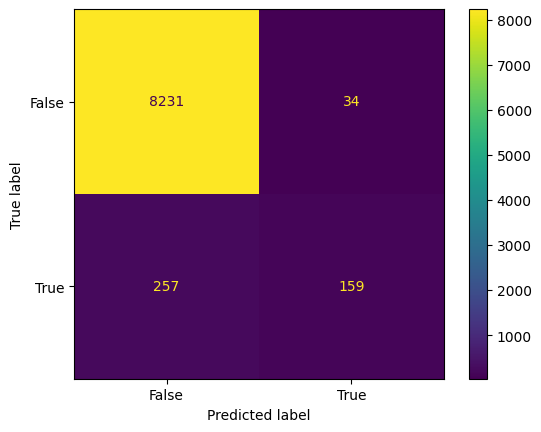

In [26]:
# Plot confusion
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

Communicate Results

Feature Importances

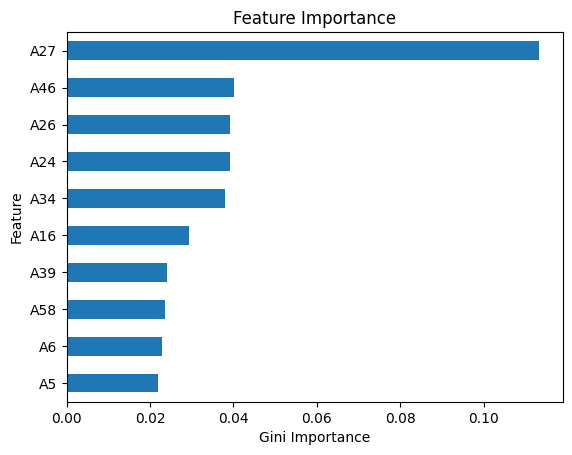

In [27]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(
    kind="barh"
)
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

Save the model

In [28]:
# Save model
with open("model-5-3.pkl", "wb") as f:
    pickle.dump(model, f)

"Make predictions" function

In [51]:
def wrangle(url):
    df = pd.read_csv(url)
    target = "bankrupt"
    X = df.drop(columns=target)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_test.to_csv("data/X_test.csv")
    
    return df

In [52]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="bankrupt")
    return y_test_pred

Making a prediction with the function

In [48]:
# creating a new testing test for the test


In [ ]:
y_test_pred = make_predictions(
    data_filepath= ("data/X_test.csv"),
    model_filepath="model-5-3.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()